# 🎯 Hyperparameter Tuning: Оптимизация CatBoost с Optuna (GPU)

Этот ноутбук посвящен **автоматической оптимизации гиперпараметров** модели CatBoost с использованием фреймворка **Optuna** и ускорения на **GPU**.

---

## 📋 Содержание

### 1. **Подготовка данных**
- Загрузка предобработанного датасета (`hyperparam_tuning.csv`)
- Сортировка по времени (`TransactionDT`) для предотвращения утечки данных
- Проверка дисбаланса классов (соотношение 1:28, fraud 3.50%)

### 2. **Isolation Forest: Детектирование аномалий**
- Обучение Isolation Forest на числовых признаках для выявления аномальных транзакций
- Создание дополнительных признаков:
  - `iso_forest_score` — степень аномальности транзакции
  - `iso_forest_anomaly` — бинарный флаг аномалии (0/1)

### 3. **Optuna: Автоматический поиск гиперпараметров**
- **Цель**: Максимизация ROC-AUC на кросс-валидации (TimeSeriesSplit, 5 фолдов)
- **Количество испытаний**: 5 trials (каждое ≈ 15-30 минут на GPU)
- **Общее время**: ~68.8 минут

### 4. **Результаты оптимизации**
- **Лучший ROC-AUC**: 0.9124 ± 0.0102 (Trial #1)
- **Лучшие параметры**:
  - `depth`: 8
  - `learning_rate`: 0.0063
  - `iterations`: 4371
  - `bootstrap_type`: Bernoulli
  - `l2_leaf_reg`: 2.76
  - `min_data_in_leaf`: 32

### 5. **Топ-10 важных признаков** (по CatBoost Feature Importance)
1. **C10** (счётчик) — 5.28%
2. **C13** (счётчик) — 4.90%
3. **C11** (счётчик) — 4.85%
4. **P_emaildomain** (категория) — 3.60%
5. **card1** (категория) — 3.24%
6. **UID** (комбинированный идентификатор) — 3.12%
7. **M5** (категория) — 2.77%
8. **D2** (временная дельта) — 2.71%
9. **iso_forest_score** (аномалия) — 2.61%
10. **R_emaildomain** (категория) — 2.31%

### 6. **Финальная модель на последнем фолде**
- **ROC-AUC на валидации**: 0.9290
- **Оптимальный порог** (по бизнес-стоимости): 0.60
  - False Positive Rate × $10 + False Negative Rate × $100
  - **Минимальная стоимость**: $149,100
- **Метрики с порогом 0.60**:
  - Precision: 0.3902
  - Recall: 0.6650
  - F1-Score: 0.4918
  - Accuracy: 0.9526

---

## 🚀 Ключевые отличия от предыдущих ноутбуков

| Аспект | Предыдущие ноутбуки | Этот ноутбук |
|--------|---------------------|--------------|
| **Гиперпараметры** | Подбор вручную | **Автоматическая оптимизация Optuna** |
| **Валидация** | Holdout (train/test split) | **TimeSeriesSplit (5 фолдов)** |
| **Feature Engineering** | Базовые признаки | + **Isolation Forest аномалии** |
| **Ускорение** | CPU | **GPU (CUDA)** |
| **Итерации обучения** | Фиксированное число | **Early Stopping + Optuna Pruning** |

---

## 📊 Визуализации

1. **Isolation Forest**: Распределение anomaly scores для fraud/non-fraud
2. **Optuna Optimization History**: Динамика ROC-AUC по trials
3. **Optuna Hyperparameter Importances**: Какие параметры влияют на качество
4. **Feature Importance**: Топ-20 признаков по Gain/Split/ShapValues
5. **ROC-Curve & PR-Curve**: Качество классификации на валидации
6. **Confusion Matrix**: Ошибки False Positive/False Negative
7. **Threshold Optimization**: Подбор порога по F1-Score и бизнес-стоимости

---

## ⚙️ Требования

- **GPU с CUDA** (Tesla T4 / V100 / A100 на Colab)
- **CatBoost 1.2+** с поддержкой GPU
- **Optuna 3.0+** для оптимизации

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print("🔄 Установка библиотек...")

# Тихая установка (без вывода логов)
!pip install -q catboost
!pip install -q optuna

print("✅ Все библиотеки установлены!")

🔄 Установка библиотек...
✅ Все библиотеки установлены!


In [ ]:
import catboost as cb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import warnings
import time
from datetime import datetime
import json
warnings.filterwarnings('ignore')
from matplotlib.patches import Patch

from sklearn.ensemble import RandomForestClassifier, IsolationForest  

In [3]:
import sys
import os

# Путь к вашей папке с модулями
project_path = '/content/drive/MyDrive/ieee_fraud_detection'

# Проверяем, что папка существует
if os.path.exists(project_path):
    print(f"✓ Папка найдена: {project_path}")

    # Показываем файлы
    print("\nФайлы в папке:")
    for f in os.listdir(project_path):
        print(f"  - {f}")

    # Добавляем путь
    if project_path not in sys.path:
        sys.path.insert(0, project_path)

    # Меняем рабочую директорию (важно для Colab!)
    os.chdir(project_path)

    print(f"\n✓ Рабочая директория: {os.getcwd()}")

    # Теперь импортируем
    from helper import *
    from plots import *

    print("✓ Модули успешно импортированы!")
else:
    print(f"✗ Папка не найдена: {project_path}")
    print("Подключите Drive: drive.mount('/content/drive')")


✓ Папка найдена: /content/drive/MyDrive/ieee_fraud_detection

Файлы в папке:
  - 04_hyperparam_tuning-Copy1 (3).ipynb
  - train_identity.csv
  - train_transaction.csv
  - __pycache__
  - catboost_info
  - Копия блокнота "04_improvements_Cat-CUDA.ipynb"
  - hyperparam_tuning.csv
  - 04_improvements_Cat-CUDA.ipynb
  - catboost_optuna_fraud_model_gpu.cbm
  - best_catboost_params_gpu.json
  - helper.py
  - plots.py

✓ Рабочая директория: /content/drive/MyDrive/ieee_fraud_detection
✓ Модули успешно импортированы!


In [4]:
# Загрузка данных
train = pd.read_csv('/content/drive/MyDrive/ieee_fraud_detection/hyperparam_tuning.csv')

In [5]:
# ============================================================================
# ПРОВЕРКА GPU
# ============================================================================

print(f"[{datetime.now().strftime('%H:%M:%S')}] 🔍 Проверка доступности GPU...")
try:
    from catboost.utils import get_gpu_device_count
    gpu_count = get_gpu_device_count()
    print(f"   ✅ Доступно GPU устройств: {gpu_count}")
    if gpu_count > 0:
        print("   ⚡ CUDA ВКЛЮЧЕНА! Режим ускорения активирован.")
        TASK_TYPE = 'GPU'
    else:
        print("   ⚠️  GPU не найден. Используется CPU режим.")
        TASK_TYPE = 'CPU'
except Exception as e:
    print(f"   ⚠️  Ошибка проверки GPU: {e}")
    print("   Будет использован CPU режим")
    TASK_TYPE = 'CPU'

# ============================================================================
# ПОДГОТОВКА ДАННЫХ
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🚀 Начало подготовки данных...")

# КРИТИЧНО! Сортируем по времени
train = train.sort_values('TransactionDT').reset_index(drop=True)
X = train.drop('isFraud', axis=1)
y = train['isFraud']

X = X.loc[train.index]
y = y.loc[train.index]

print("✅ Отсортировано по TransactionDT")
print(f"Время: {train['TransactionDT'].min()} - {train['TransactionDT'].max()}")

# ============================================================================
# ОПРЕДЕЛЕНИЕ И ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🔧 Определение категориальных признаков...")
categorical_features = get_categorical_features(X)

print(f"[{datetime.now().strftime('%H:%M:%S')}] 🔄 Преобразование категориальных признаков...")
X, categorical_features = prepare_categorical_features(X, categorical_features)

cat_features_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

print(f"✅ Обработано {len(categorical_features)} категориальных признаков")
print(f"   Примеры: {', '.join(categorical_features[:5])}")

# ============================================================================
# ПРОВЕРКА НА NaN И ДИСБАЛАНС КЛАССОВ
# ============================================================================

print(f"\n🔍 ПРОВЕРКА ДАННЫХ:")
nan_count = X.isna().sum().sum()
if nan_count > 0:
    print(f"⚠️  Найдено {nan_count} пропущенных значений в числовых признаках")
    print(f"   CatBoost обработает их автоматически через nan_mode='Min'")
else:
    print(f"✅ Пропущенных значений не обнаружено")

fraud_rate = y.mean()
print(f"\n📊 ДИСБАЛАНС КЛАССОВ:")
print(f"   Fraud: {y.sum()} ({fraud_rate*100:.2f}%)")
print(f"   No Fraud: {len(y) - y.sum()} ({(1-fraud_rate)*100:.2f}%)")
print(f"   Соотношение: 1:{int(1/fraud_rate)}")

scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"   Scale_pos_weight для CatBoost: {scale_pos_weight:.2f}")

[15:03:34] 🔍 Проверка доступности GPU...
   ✅ Доступно GPU устройств: 1
   ⚡ CUDA ВКЛЮЧЕНА! Режим ускорения активирован.

[15:03:34] 🚀 Начало подготовки данных...
✅ Отсортировано по TransactionDT
Время: 86400 - 15811131

[15:03:36] 🔧 Определение категориальных признаков...
   ⚠️  Найдена object (string) колонка: time_period
   ⚠️  Найдена object (string) колонка: time_amt_category
   ⚠️  Найдена object (string) колонка: UID
   ⚠️  Найдена object (string) колонка: card1_addr1
   ⚠️  Найдена object (string) колонка: device_browser
   ⚠️  Найдена object (string) колонка: device_os
   ⚠️  Найдена object (string) колонка: device_type
   ⚠️  Найдена object (string) колонка: device_vendor
   ⚠️  Найдена object (string) колонка: device_email_combination
   ⚠️  Найдена object (string) колонка: TransactionAmt_bin
[15:03:36] 🔄 Преобразование категориальных признаков...

🔧 Преобразование категориальных и проблемных признаков...

🔍 Проверка смешанных типов данных...

✅ Преобразовано 32 категориальн


🌲 ISOLATION FOREST: ПОИСК АНОМАЛИЙ (без утечки данных)

[15:03:44] 🔍 Подготовка данных для Isolation Forest...
   Числовых признаков: 145
   Train size: 393,694, Val size: 196,846

[15:03:47] 🌲 Обучение Isolation Forest на TRAIN...
   Стандартизация признаков (fit на train)...
✅ Isolation Forest обучен на train

[15:04:07] 🔄 Применение IF к валидации...
✅ IF применён к валидации без утечки

📊 РЕЗУЛЬТАТЫ ISOLATION FOREST (только VAL):
   Обнаружено аномалий: 8,063 (4.10%)
   Ожидаемый fraud: 7,083 (3.60%)

   Качество обнаружения fraud (Isolation Forest на VAL):
              precision    recall  f1-score   support

    No Fraud       0.97      0.96      0.97    189763
       Fraud       0.15      0.17      0.16      7083

    accuracy                           0.94    196846
   macro avg       0.56      0.57      0.56    196846
weighted avg       0.94      0.94      0.94    196846


✅ Добавлено 2 новых признака:
   - iso_forest_score: степень аномальности
   - iso_forest_anomaly: флаг

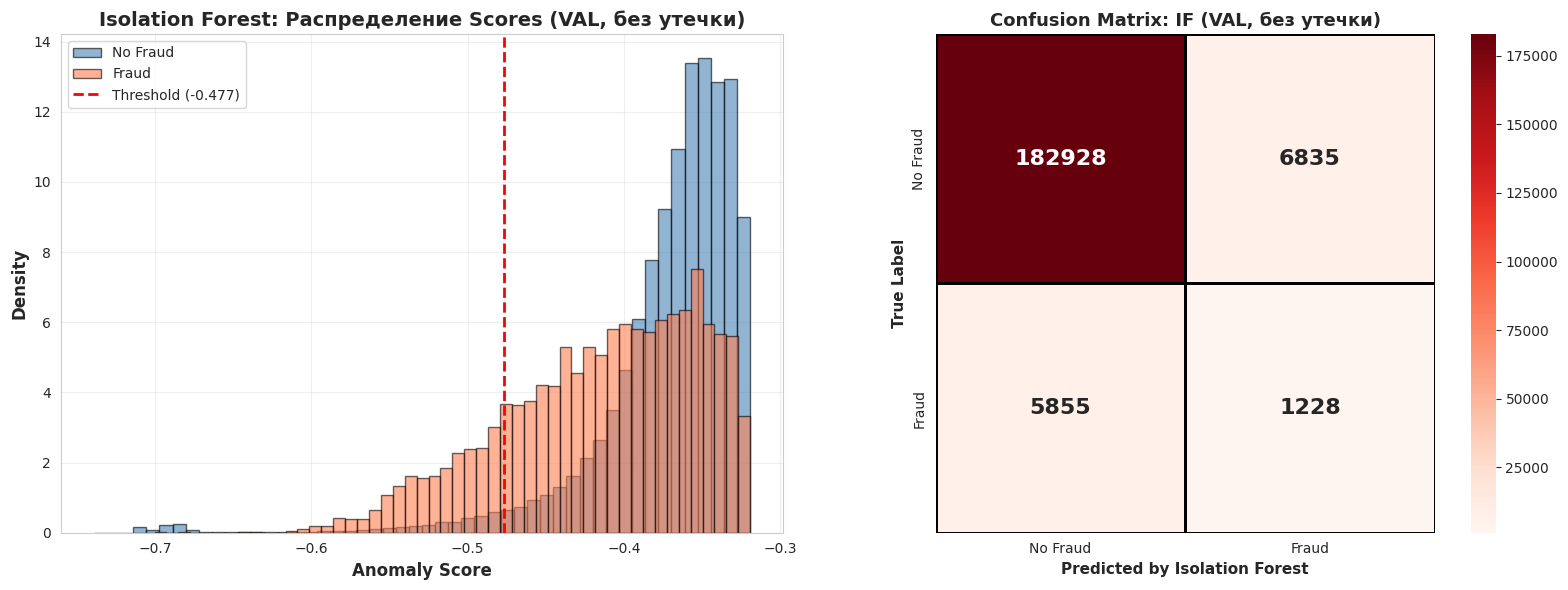


🎯 МЕТРИКИ ISOLATION FOREST (только VAL, без утечки):
   PR-AUC (основная метрика): 0.0986
   ROC-AUC (доп. метрика):     0.7215

✅ ISOLATION FOREST ГОТОВ! Признаки добавлены БЕЗ УТЕЧКИ!


In [6]:
# ============================================================================
# ISOLATION FOREST: ОБНАРУЖЕНИЕ АНОМАЛИЙ (БЕЗ УТЕЧКИ)
# ============================================================================

print("\n" + "="*100)
print("🌲 ISOLATION FOREST: ПОИСК АНОМАЛИЙ (без утечки данных)")
print("="*100)

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🔍 Подготовка данных для Isolation Forest...")

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"   Числовых признаков: {len(numeric_features)}")

# ⚠️ ВАЖНО: Разбиваем данные ДО обучения IF!
# Используем TimeSeriesSplit чтобы получить один train/val split
tscv_temp = TimeSeriesSplit(n_splits=2)  # минимум 2 фолда для получения split
train_idx_temp, val_idx_temp = list(tscv_temp.split(X))[-1]  # берём последний split

X_train_temp = X.iloc[train_idx_temp].copy()
X_val_temp = X.iloc[val_idx_temp].copy()
y_train_temp = y.iloc[train_idx_temp]
y_val_temp = y.iloc[val_idx_temp]

print(f"   Train size: {len(X_train_temp):,}, Val size: {len(X_val_temp):,}")

# ============================================================================
# ОБУЧЕНИЕ IF ТОЛЬКО НА TRAIN
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🌲 Обучение Isolation Forest на TRAIN...")

X_numeric_train = X_train_temp[numeric_features].copy()
train_medians = X_numeric_train.median()  # медианы ТОЛЬКО из train
X_numeric_filled_train = X_numeric_train.fillna(train_medians)

print(f"   Стандартизация признаков (fit на train)...")
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_numeric_filled_train)

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples=min(256, len(X_train_temp)),
    contamination=fraud_rate,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

iso_forest.fit(X_scaled_train)

# Scores для TRAIN
anomaly_labels_train = iso_forest.predict(X_scaled_train)
anomaly_scores_train = iso_forest.score_samples(X_scaled_train)

print("✅ Isolation Forest обучен на train")

# ============================================================================
# ПРИМЕНЕНИЕ IF К VAL (без утечки!)
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🔄 Применение IF к валидации...")

X_numeric_val = X_val_temp[numeric_features].copy()
X_numeric_filled_val = X_numeric_val.fillna(train_medians)  # медианы из TRAIN!
X_scaled_val = scaler.transform(X_numeric_filled_val)  # только transform!

# Scores для VAL
anomaly_labels_val = iso_forest.predict(X_scaled_val)
anomaly_scores_val = iso_forest.score_samples(X_scaled_val)

print("✅ IF применён к валидации без утечки")

# ============================================================================
# РЕЗУЛЬТАТЫ (только на VAL!)
# ============================================================================

n_anomalies_val = (anomaly_labels_val == -1).sum()
print(f"\n📊 РЕЗУЛЬТАТЫ ISOLATION FOREST (только VAL):")
print(f"   Обнаружено аномалий: {n_anomalies_val:,} ({n_anomalies_val/len(X_val_temp)*100:.2f}%)")
print(f"   Ожидаемый fraud: {y_val_temp.sum():,} ({y_val_temp.mean()*100:.2f}%)")

from sklearn.metrics import classification_report, average_precision_score
print(f"\n   Качество обнаружения fraud (Isolation Forest на VAL):")
print(classification_report(y_val_temp, (anomaly_labels_val == -1).astype(int),
                            target_names=['No Fraud', 'Fraud']))

# ============================================================================
# ДОБАВЛЕНИЕ ПРИЗНАКОВ В ПОЛНЫЙ ДАТАСЕТ
# ============================================================================

# Инициализируем колонки
X['iso_forest_score'] = 0.0
X['iso_forest_anomaly'] = 0

# Заполняем train
X.loc[train_idx_temp, 'iso_forest_score'] = anomaly_scores_train
X.loc[train_idx_temp, 'iso_forest_anomaly'] = (anomaly_labels_train == -1).astype(int)

# Заполняем val
X.loc[val_idx_temp, 'iso_forest_score'] = anomaly_scores_val
X.loc[val_idx_temp, 'iso_forest_anomaly'] = (anomaly_labels_val == -1).astype(int)

print("\n✅ Добавлено 2 новых признака:")
print("   - iso_forest_score: степень аномальности")
print("   - iso_forest_anomaly: флаг аномалии (0/1)")
print("   ⚠️ Признаки рассчитаны БЕЗ утечки (train и val отдельно)")

# ============================================================================
# ВИЗУАЛИЗАЦИЯ (только VAL!)
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 📊 Визуализация результатов (только VAL)...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Распределение scores
axes[0].hist(anomaly_scores_val[y_val_temp == 0], bins=50, alpha=0.6, color='steelblue',
             label='No Fraud', edgecolor='black', density=True)
axes[0].hist(anomaly_scores_val[y_val_temp == 1], bins=50, alpha=0.6, color='coral',
             label='Fraud', edgecolor='black', density=True)
axes[0].axvline(x=iso_forest.offset_, color='red', linestyle='--', linewidth=2,
                label=f'Threshold ({iso_forest.offset_:.3f})')
axes[0].set_xlabel('Anomaly Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0].set_title('Isolation Forest: Распределение Scores (VAL, без утечки)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# График 2: Confusion Matrix
import seaborn as sns
cm_iso = confusion_matrix(y_val_temp, (anomaly_labels_val == -1).astype(int))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'],
            cbar=True, square=True, linewidths=2,
            linecolor='black', annot_kws={"size": 16, "weight": "bold"}, ax=axes[1])
axes[1].set_xlabel('Predicted by Isolation Forest', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_title('Confusion Matrix: IF (VAL, без утечки)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# МЕТРИКИ (основная: PR-AUC)
# ============================================================================

iso_pr_auc = average_precision_score(y_val_temp, -anomaly_scores_val)
iso_roc_auc = roc_auc_score(y_val_temp, -anomaly_scores_val)

print(f"\n🎯 МЕТРИКИ ISOLATION FOREST (только VAL, без утечки):")
print(f"   PR-AUC (основная метрика): {iso_pr_auc:.4f}")
print(f"   ROC-AUC (доп. метрика):     {iso_roc_auc:.4f}")

print("\n" + "="*100)
print("✅ ISOLATION FOREST ГОТОВ! Признаки добавлены БЕЗ УТЕЧКИ!")
print("="*100)

[I 2026-02-01 15:04:51,988] A new study created in memory with name: catboost_fraud_detection_gpu_prauc



⚠️  ПРОВЕРКА: Isolation Forest признаки найдены в X
   ✅ iso_forest_score: OK
   ✅ iso_forest_anomaly: OK
   ⚠️  Убедитесь, что IF обучался БЕЗ утечки (train/val раздельно)!

⚡ OPTUNA + GPU: АВТОМАТИЧЕСКАЯ ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ

🚀 Запуск оптимизации Optuna...
   Количество испытаний: 5
   Метрика: PR-AUC (Precision-Recall AUC, усредненная по TimeSeriesSplit)
   Старт: 15:04:51

[15:04:51] TRIAL #1/5 (GPU)
   📋 Параметры:
      bootstrap_type: Bernoulli
      depth: 8, lr: 0.0063, iterations: 4371
      l2_leaf_reg: 2.76, min_data_in_leaf: 32
      auto_class_weights: Balanced, border_count: 32

   [15:04:51] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...
      Fold 1/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.4864, ROC-AUC=0.8929 (best_iter=1191, time=64.5s)
      Fold 2/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5697, ROC-AUC=0.9111 (best_iter=1859, time=129.3s)
      Fold 3/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5389, ROC-AUC=0.9091 (best_iter=3302, time=272.0s)
      Fold 4/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5894, ROC-AUC=0.9248 (best_iter=3034, time=310.4s)
      Fold 5/5: 

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-01 15:25:57,136] Trial 0 finished with value: 0.5521802606472392 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 8, 'l2_leaf_reg': 2.7622702864153297, 'min_data_in_leaf': 32, 'learning_rate': 0.006342368214226896, 'iterations': 4371, 'auto_class_weights': 'Balanced', 'border_count': 32, 'one_hot_max_size': 10, 'random_strength': 3.0424224295953772, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 2, 'subsample': 0.645614570099021}. Best is trial 0 with value: 0.5521802606472392.


PR-AUC=0.5765, ROC-AUC=0.9297 (best_iter=4030, time=488.8s)

   🎉 НОВЫЙ РЕКОРД! PR-AUC: 0.5522 ± 0.0369 | ROC-AUC: 0.9135
   ⏱️  Trial time: 1264.9s | Total: 21.1min | ETA: 84.3min

[15:25:57] TRIAL #2/5 (GPU)
   📋 Параметры:
      bootstrap_type: Bayesian
      depth: 6, lr: 0.0113, iterations: 2717
      l2_leaf_reg: 7.11, min_data_in_leaf: 158
      auto_class_weights: SqrtBalanced, border_count: 254

   [15:25:57] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...
      Fold 1/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5116, ROC-AUC=0.8866 (best_iter=2641, time=82.0s)
      Fold 2/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5429, ROC-AUC=0.9007 (best_iter=2710, time=114.2s)
      Fold 3/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5019, ROC-AUC=0.8948 (best_iter=2711, time=150.3s)
      Fold 4/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5470, ROC-AUC=0.9100 (best_iter=2678, time=190.2s)
      Fold 5/5: 

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-01 15:38:45,678] Trial 1 finished with value: 0.5217782239498979 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 6, 'l2_leaf_reg': 7.113014771147021, 'min_data_in_leaf': 158, 'learning_rate': 0.011324530081857673, 'iterations': 2717, 'auto_class_weights': 'SqrtBalanced', 'border_count': 254, 'one_hot_max_size': 41, 'random_strength': 3.0461376917337066, 'leaf_estimation_iterations': 1, 'max_ctr_complexity': 3, 'bagging_temperature': 4.4015249373960135}. Best is trial 0 with value: 0.5521802606472392.


PR-AUC=0.5055, ROC-AUC=0.9128 (best_iter=2715, time=231.6s)

   ⚪ PR-AUC: 0.5218 ± 0.0192 (лучший: 0.5522) | ROC-AUC: 0.9010
   ⏱️  Trial time: 768.4s | Total: 33.9min | ETA: 50.8min

[15:38:45] TRIAL #3/5 (GPU)
   📋 Параметры:
      bootstrap_type: Bernoulli
      depth: 12, lr: 0.0179, iterations: 2744
      l2_leaf_reg: 4.25, min_data_in_leaf: 133
      auto_class_weights: SqrtBalanced, border_count: 64

   [15:38:45] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...
      Fold 1/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5104, ROC-AUC=0.8886 (best_iter=325, time=47.7s)
      Fold 2/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5786, ROC-AUC=0.9048 (best_iter=896, time=105.5s)
      Fold 3/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5446, ROC-AUC=0.9055 (best_iter=1090, time=128.7s)
      Fold 4/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5907, ROC-AUC=0.9221 (best_iter=1101, time=137.3s)
      Fold 5/5: 

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-01 15:49:10,907] Trial 2 finished with value: 0.5568244311803546 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 12, 'l2_leaf_reg': 4.252309733200246, 'min_data_in_leaf': 133, 'learning_rate': 0.017915933593754683, 'iterations': 2744, 'auto_class_weights': 'SqrtBalanced', 'border_count': 64, 'one_hot_max_size': 47, 'random_strength': 0.884925020519195, 'leaf_estimation_iterations': 2, 'max_ctr_complexity': 1, 'subsample': 0.6626651653816322}. Best is trial 2 with value: 0.5568244311803546.


PR-AUC=0.5599, ROC-AUC=0.9236 (best_iter=1716, time=205.8s)

   🎉 НОВЫЙ РЕКОРД! PR-AUC: 0.5568 ± 0.0281 | ROC-AUC: 0.9089
   ⏱️  Trial time: 625.0s | Total: 44.3min | ETA: 29.5min

[15:49:10] TRIAL #4/5 (GPU)
   📋 Параметры:
      bootstrap_type: MVS
      depth: 6, lr: 0.0089, iterations: 4071
      l2_leaf_reg: 4.57, min_data_in_leaf: 109
      auto_class_weights: Balanced, border_count: 128

   [15:49:10] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...
      Fold 1/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.3700, ROC-AUC=0.8708 (best_iter=4000, time=109.6s)
      Fold 2/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.4880, ROC-AUC=0.8972 (best_iter=3442, time=134.9s)
      Fold 3/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.4463, ROC-AUC=0.8800 (best_iter=2637, time=136.3s)
      Fold 4/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.2385, ROC-AUC=0.7809 (best_iter=174, time=27.0s)
      Fold 5/5: 

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-01 16:00:54,704] Trial 3 finished with value: 0.40544177350141564 and parameters: {'bootstrap_type': 'MVS', 'depth': 6, 'l2_leaf_reg': 4.573550390467021, 'min_data_in_leaf': 109, 'learning_rate': 0.008903373471352116, 'iterations': 4071, 'auto_class_weights': 'Balanced', 'border_count': 128, 'one_hot_max_size': 37, 'random_strength': 7.712703466859457, 'leaf_estimation_iterations': 1, 'max_ctr_complexity': 2}. Best is trial 2 with value: 0.5568244311803546.


PR-AUC=0.4845, ROC-AUC=0.9012 (best_iter=4070, time=295.8s)

   ⚪ PR-AUC: 0.4054 ± 0.0937 (лучший: 0.5568) | ROC-AUC: 0.8660
   ⏱️  Trial time: 703.6s | Total: 56.0min | ETA: 14.0min

[16:00:54] TRIAL #5/5 (GPU)
   📋 Параметры:
      bootstrap_type: Bernoulli
      depth: 6, lr: 0.0189, iterations: 3729
      l2_leaf_reg: 1.42, min_data_in_leaf: 63
      auto_class_weights: Balanced, border_count: 128

   [16:00:54] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...
      Fold 1/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.4720, ROC-AUC=0.8902 (best_iter=548, time=26.0s)
      Fold 2/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5606, ROC-AUC=0.9099 (best_iter=986, time=54.2s)
      Fold 3/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5371, ROC-AUC=0.9096 (best_iter=2064, time=126.8s)
      Fold 4/5: 

Default metric period is 5 because AUC is/are not implemented for GPU


PR-AUC=0.5787, ROC-AUC=0.9250 (best_iter=1794, time=140.2s)
      Fold 5/5: 

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-01 16:09:36,899] Trial 4 finished with value: 0.5427153923641924 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 6, 'l2_leaf_reg': 1.4215960791473428, 'min_data_in_leaf': 63, 'learning_rate': 0.018931940679617305, 'iterations': 3729, 'auto_class_weights': 'Balanced', 'border_count': 128, 'one_hot_max_size': 39, 'random_strength': 4.937955963643907, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 2, 'subsample': 0.5127095633720475}. Best is trial 2 with value: 0.5568244311803546.


PR-AUC=0.5652, ROC-AUC=0.9281 (best_iter=1862, time=174.8s)

   ⚪ PR-AUC: 0.5427 ± 0.0378 (лучший: 0.5568) | ROC-AUC: 0.9126
   ⏱️  Trial time: 522.0s | Total: 64.7min | ETA: 0.0min

✅ ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!
   Финиш: 16:09:36
   Общее время: 64.7 минут

🏆 ЛУЧШИЕ ПАРАМЕТРЫ:
   Best PR-AUC: 0.5568
   Best Trial: #3

   Параметры:
      bootstrap_type: Bernoulli
      depth: 12
      l2_leaf_reg: 4.252309733200246
      min_data_in_leaf: 133
      learning_rate: 0.017915933593754683
      iterations: 2744
      auto_class_weights: SqrtBalanced
      border_count: 64
      one_hot_max_size: 47
      random_strength: 0.884925020519195
      leaf_estimation_iterations: 2
      max_ctr_complexity: 1
      subsample: 0.6626651653816322

[16:09:36] 📊 Построение графиков Optuna...


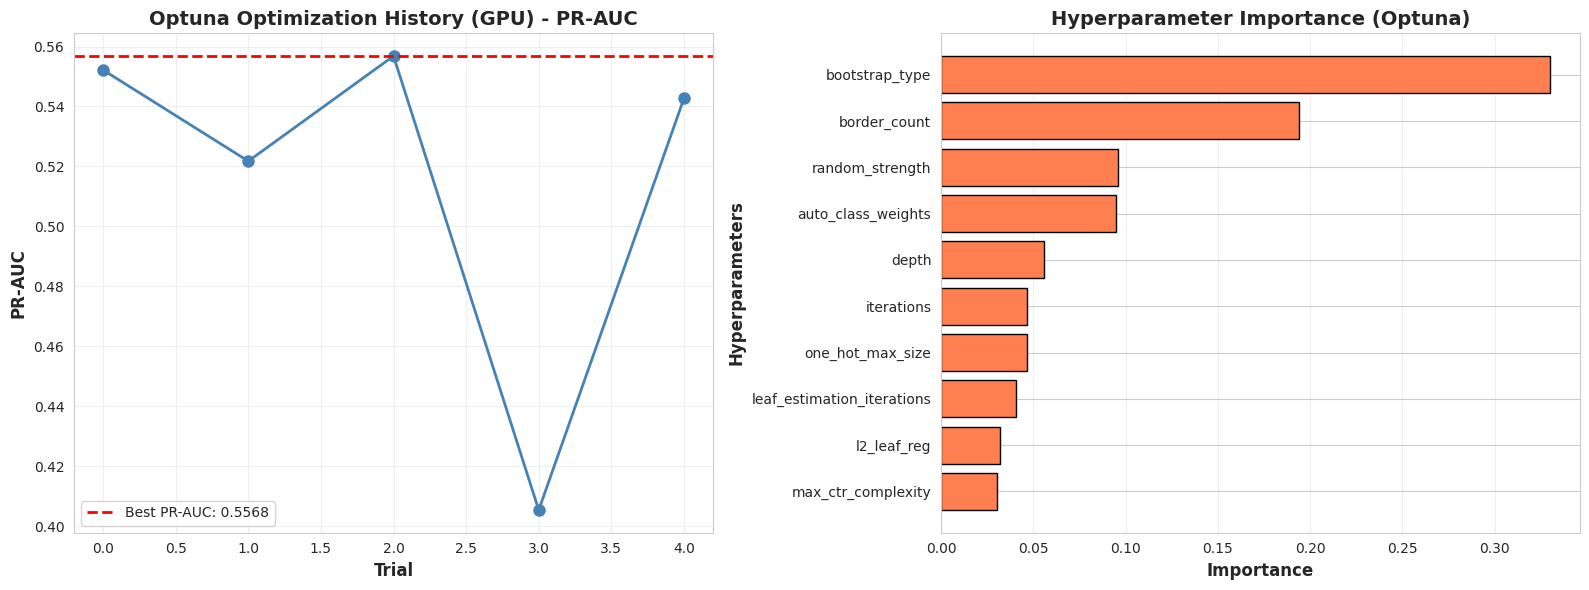


🏋️ ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ОПТИМИЗИРОВАННЫМИ ПАРАМЕТРАМИ (GPU)

📋 Финальные параметры:
   bootstrap_type: Bernoulli
   depth: 12
   l2_leaf_reg: 4.252309733200246
   min_data_in_leaf: 133
   learning_rate: 0.017915933593754683
   iterations: 2744
   auto_class_weights: SqrtBalanced
   border_count: 64
   one_hot_max_size: 47
   random_strength: 0.884925020519195
   leaf_estimation_iterations: 2
   max_ctr_complexity: 1
   subsample: 0.6626651653816322
   task_type: GPU
   nan_mode: Min
   eval_metric: AUC
   early_stopping_rounds: 100
   random_seed: 42
   verbose: 0
   devices: 0

[16:09:37] 🔄 Полная кросс-валидация (5 фолдов)...
   Fold 1/5: обучение...

Default metric period is 5 because AUC is/are not implemented for GPU


 PR-AUC=0.5104, ROC-AUC=0.8886 | Best iter: 325 | Time: 42.6s
   Fold 2/5: обучение...

Default metric period is 5 because AUC is/are not implemented for GPU


 PR-AUC=0.5786, ROC-AUC=0.9048 | Best iter: 896 | Time: 99.1s
   Fold 3/5: обучение...

Default metric period is 5 because AUC is/are not implemented for GPU


 PR-AUC=0.5435, ROC-AUC=0.9046 | Best iter: 1103 | Time: 124.0s
   Fold 4/5: обучение...

Default metric period is 5 because AUC is/are not implemented for GPU


 PR-AUC=0.5907, ROC-AUC=0.9221 | Best iter: 1101 | Time: 129.0s
   Fold 5/5: обучение...

Default metric period is 5 because AUC is/are not implemented for GPU


 PR-AUC=0.5515, ROC-AUC=0.9231 | Best iter: 1379 | Time: 164.7s

📊 CV Метрики (оптимизированная модель):
   PR-AUC:  0.5549 ± 0.0282
   ROC-AUC: 0.9087 ± 0.0128

[16:18:57] 🔍 Анализ важности признаков...

🔄 СТАБИЛЬНОСТЬ ПРИЗНАКОВ ПО ФОЛДАМ:
Фолд       Топ-1 признак                  Важность       
Fold 1     card1_addr1                    7.5312         
Fold 2     card1_addr1                    8.5883         
Fold 3     card1_addr1                    8.9584         
Fold 4     card1_addr1                    10.0887        
Fold 5     card1_addr1                    9.8369         

🔥 ТОП-10 ПРИЗНАКОВ (усреднённые по всем фолдам):
   card1_addr1           [CAT]: 9.0007 ± 0.9181
   card1                 [CAT]: 5.1151 ± 0.2072
   C13                   [NUM]: 4.8627 ± 0.3452
   C11                   [NUM]: 3.7896 ± 0.7541
   card2                 [CAT]: 3.6425 ± 0.5241
   M5                    [CAT]: 3.6087 ± 0.1946
   P_emaildomain         [CAT]: 3.5358 ± 0.5586
   addr1                 

Default metric period is 5 because AUC is/are not implemented for GPU


✅ Модель обучена на последнем фолде
   Best iteration: 1357

[16:21:36] 💾 Сохранение модели...
✅ Модель сохранена в 'catboost_optuna_fraud_model_gpu.cbm'
✅ Параметры сохранены в 'best_catboost_params_gpu.json'

[16:21:36] 📊 Построение графиков важности признаков...


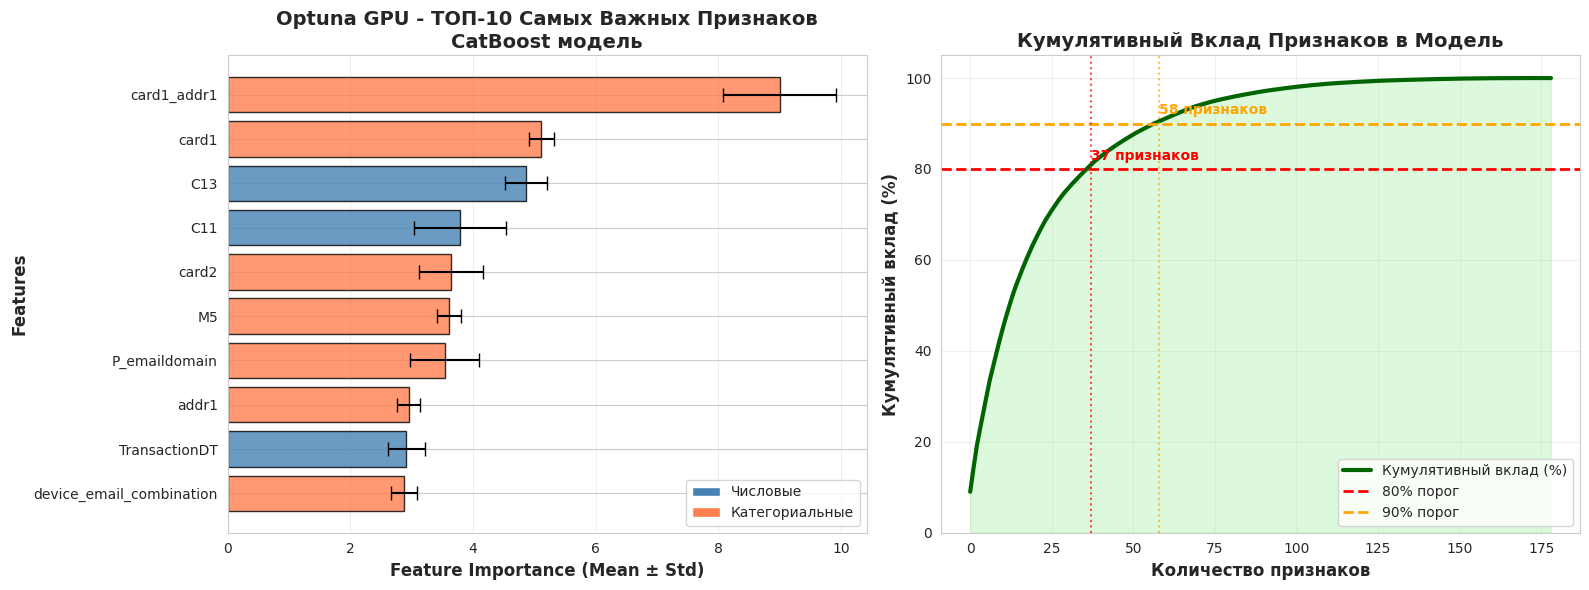


📊 АНАЛИЗ КУМУЛЯТИВНОГО ВКЛАДА ПРИЗНАКОВ:
  • Для достижения 80% важности требуется: 37 признаков (20.7%)
  • Для достижения 90% важности требуется: 58 признаков (32.4%)
  • Общее количество признаков: 179

📊 ВАРИАНТ 1: ДЕФОЛТНЫЙ ПОРОГ 0.5

МЕТРИКИ НА ТЕСТОВОЙ ЧАСТИ ДЕФОЛТНЫЙ ПОРОГ 0.5

ROC-AUC:   0.9232
PR-AUC:    0.5515
Accuracy:  0.9725
Precision: 0.6285
Recall:    0.4990
F1-Score:  0.5563

ПОСТРОЕНИЕ ГРАФИКОВ (Default Threshold 0.5)
ROC-AUC: 0.9232
PR-AUC (Average Precision): 0.5515


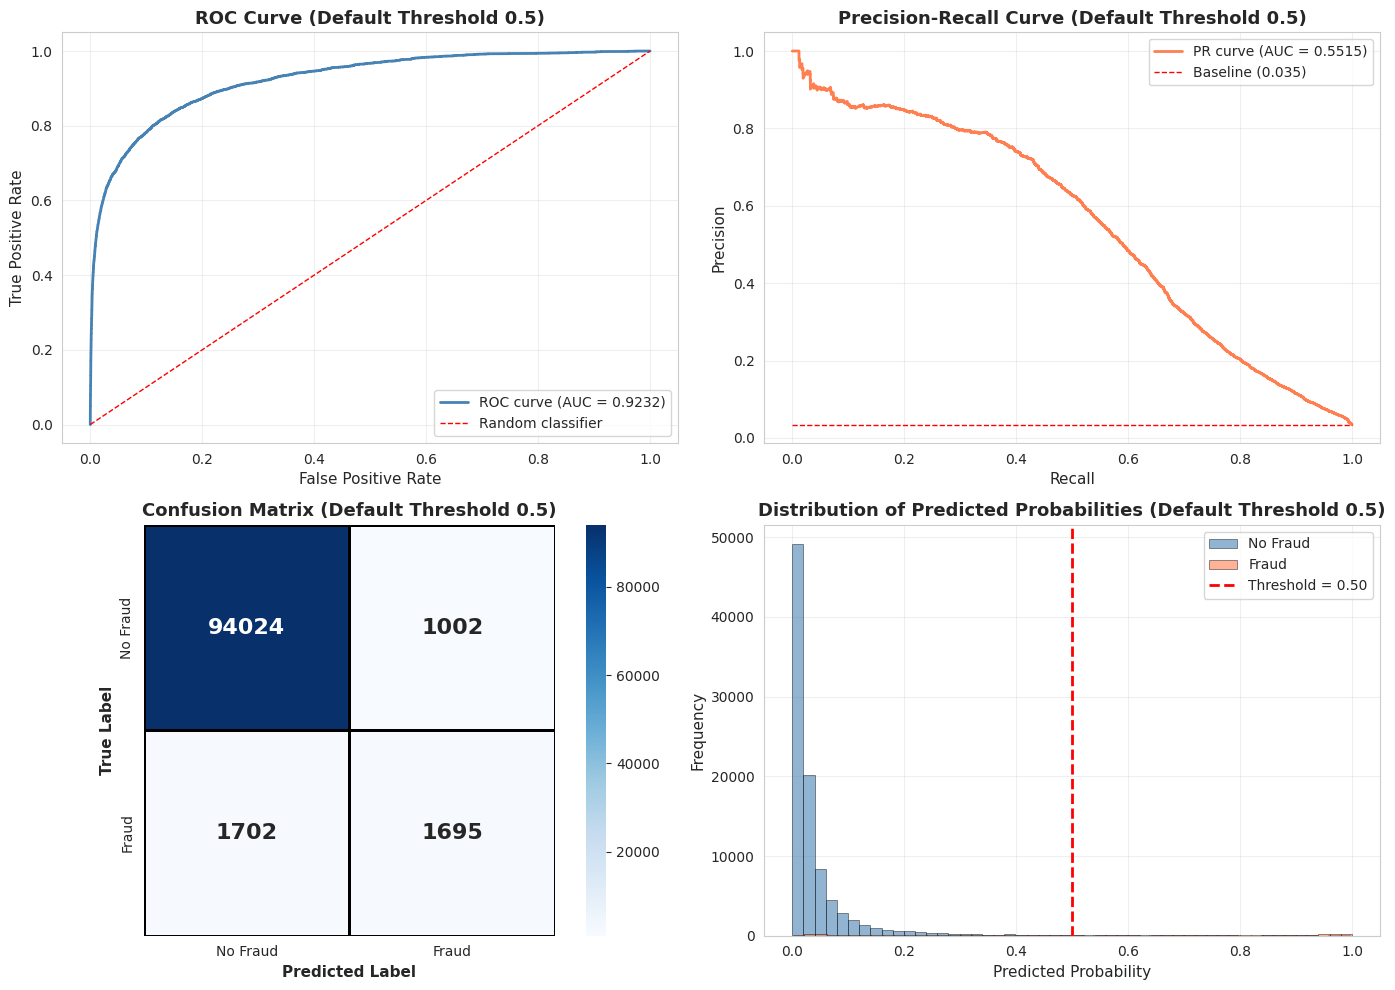


ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX (ПОРОГ 0.5)

                  Predicted
              No Fraud  |  Fraud
         ─────────────────────────
Actual   |              |        
No Fraud |     94024  |    1002
  Fraud  |      1702  |    1695

╔════════════════════════════════════════════╗
║  True Negatives  (TN):  94024 (95.53%)  ║
║  False Positives (FP):   1002 ( 1.02%)  ║
║  False Negatives (FN):   1702 ( 1.73%)  ║
║  True Positives  (TP):   1695 ( 1.72%)  ║
╚════════════════════════════════════════════╝

Дополнительные метрики из CM:
  Sensitivity (TPR, Recall): 0.4990  # доля найденного фрода
  Specificity (TNR):         0.9895  # доля правильно распознанных не-фродов
  False Positive Rate (FPR): 0.0105     # доля ложных тревог
  False Negative Rate (FNR): 0.5010     # доля пропущенного фрода

CLASSIFICATION REPORT (ПОРОГ 0.5)
              precision    recall  f1-score   support

    No Fraud       0.98      0.99      0.99     95026
       Fraud       0.63      0.50      0.56    

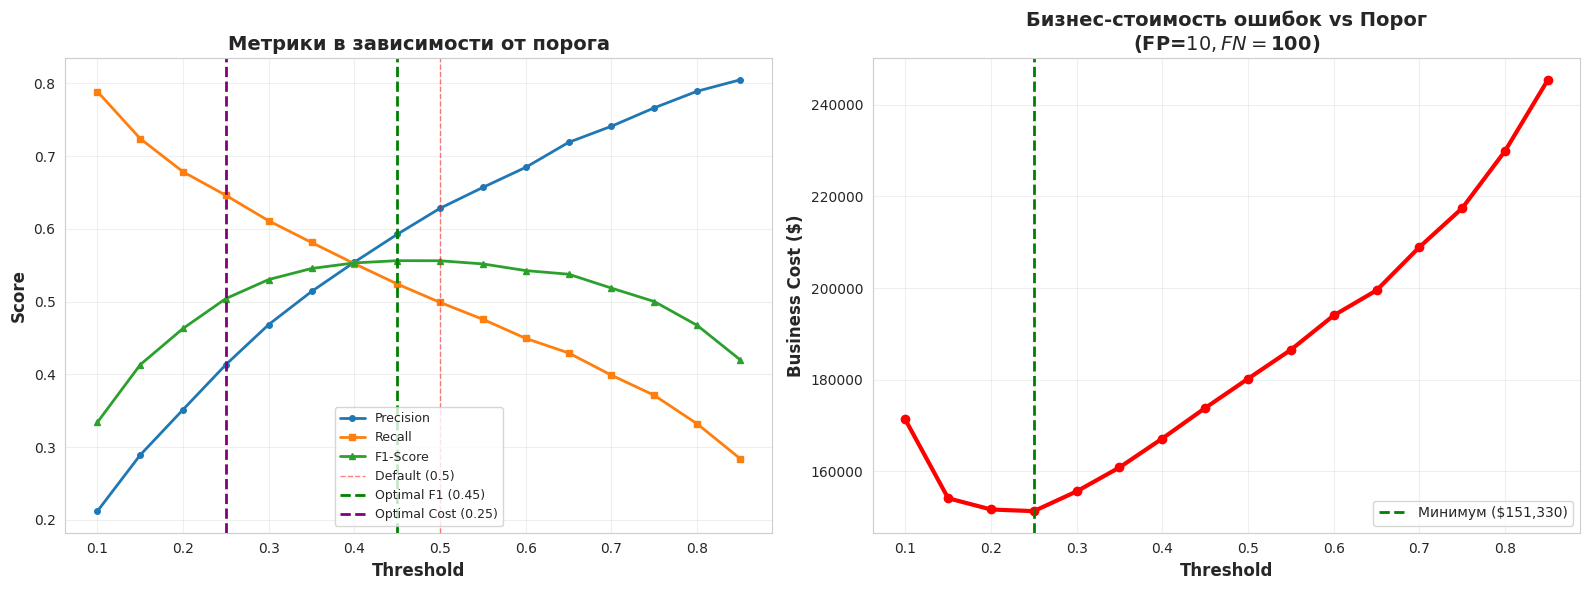


✅ ВЫБРАН ПОРОГ: 0.25 (минимизация бизнес-стоимости)

МЕТРИКИ НА ТЕСТОВОЙ ЧАСТИ ОПТИМАЛЬНЫЙ ПОРОГ 0.25

ROC-AUC:   0.9232
PR-AUC:    0.5515
Accuracy:  0.9562
Precision: 0.4135
Recall:    0.6462
F1-Score:  0.5043

ПОСТРОЕНИЕ ГРАФИКОВ (Optimal Threshold 0.25)
ROC-AUC: 0.9232
PR-AUC (Average Precision): 0.5515


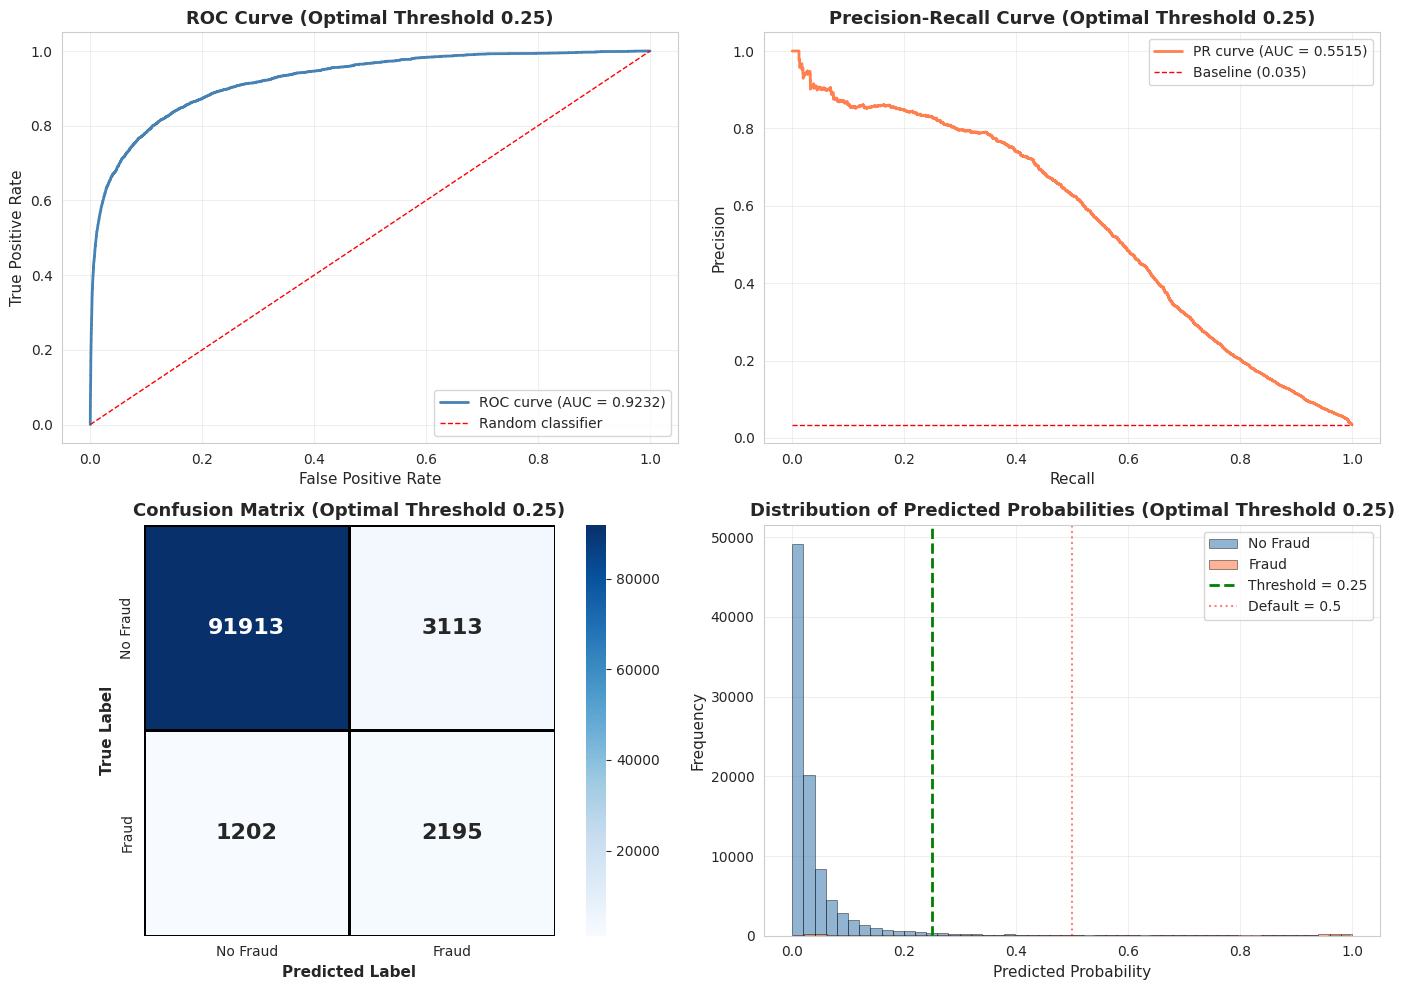


ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX (ПОРОГ 0.25)

                  Predicted
              No Fraud  |  Fraud
         ─────────────────────────
Actual   |              |        
No Fraud |     91913  |    3113
  Fraud  |      1202  |    2195

╔════════════════════════════════════════════╗
║  True Negatives  (TN):  91913 (93.39%)  ║
║  False Positives (FP):   3113 ( 3.16%)  ║
║  False Negatives (FN):   1202 ( 1.22%)  ║
║  True Positives  (TP):   2195 ( 2.23%)  ║
╚════════════════════════════════════════════╝

Дополнительные метрики из CM:
  Sensitivity (TPR, Recall): 0.6462  # доля найденного фрода
  Specificity (TNR):         0.9672  # доля правильно распознанных не-фродов
  False Positive Rate (FPR): 0.0328     # доля ложных тревог
  False Negative Rate (FNR): 0.3538     # доля пропущенного фрода

CLASSIFICATION REPORT (ПОРОГ 0.25)
              precision    recall  f1-score   support

    No Fraud       0.99      0.97      0.98     95026
       Fraud       0.41      0.65      0.50  

In [7]:
# ============================================================================
# ПРОВЕРКА: IF ПРИЗНАКИ ДОЛЖНЫ БЫТЬ В X БЕЗ УТЕЧКИ!
# ============================================================================

if 'iso_forest_score' not in X.columns or 'iso_forest_anomaly' not in X.columns:
    raise ValueError("❌ ОШИБКА: Isolation Forest признаки не найдены в X! Сначала выполните блок IF.")

print("\n" + "="*100)
print("⚠️  ПРОВЕРКА: Isolation Forest признаки найдены в X")
print("="*100)
print("   ✅ iso_forest_score: OK")
print("   ✅ iso_forest_anomaly: OK")
print("   ⚠️  Убедитесь, что IF обучался БЕЗ утечки (train/val раздельно)!")

# ============================================================================
# OPTUNA: ОПРЕДЕЛЕНИЕ ФУНКЦИИ ОПТИМИЗАЦИИ
# ============================================================================

print("\n" + "="*100)
print(f"⚡ OPTUNA + {TASK_TYPE}: АВТОМАТИЧЕСКАЯ ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ")
print("="*100)

trial_counter = 0
best_prauc_so_far = 0.0
start_time = time.time()

def objective(trial):
    global trial_counter, best_prauc_so_far
    trial_counter += 1

    trial_start = time.time()
    print(f"\n{'='*80}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] TRIAL #{trial_counter}/5 ({TASK_TYPE})")
    print(f"{'='*80}")

    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])

    params = {
        'task_type': TASK_TYPE,
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 15.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 300, 5000),
        'bootstrap_type': bootstrap_type,
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128, 254]),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 50),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 4),
        'cat_features': cat_features_indices,
        'nan_mode': 'Min',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 150,
        'random_seed': 42,
        'verbose': 0
    }

    if TASK_TYPE == 'GPU':
        params['devices'] = '0'

    if bootstrap_type == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
    elif bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)

    if params['auto_class_weights'] == 'None':
        params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight',
                                                          scale_pos_weight * 0.3,
                                                          scale_pos_weight * 2.0)

    print(f"   📋 Параметры:")
    print(f"      bootstrap_type: {bootstrap_type}")
    print(f"      depth: {params['depth']}, lr: {params['learning_rate']:.4f}, iterations: {params['iterations']}")
    print(f"      l2_leaf_reg: {params['l2_leaf_reg']:.2f}, min_data_in_leaf: {params['min_data_in_leaf']}")
    print(f"      auto_class_weights: {params['auto_class_weights']}, border_count: {params['border_count']}")

    print(f"\n   [{datetime.now().strftime('%H:%M:%S')}] ⏳ Начало TimeSeriesSplit валидации (5 фолдов)...")
    tscv = TimeSeriesSplit(n_splits=5)
    prauc_scores = []
    rocauc_scores = []

    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X)):
        fold_start = time.time()
        print(f"      Fold {fold_num+1}/5: ", end='', flush=True)

        # ✅ IF признаки уже в X без утечки (рассчитаны раздельно для train/val)
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = cb.Pool(X_tr, y_tr, cat_features=cat_features_indices)
        val_pool = cb.Pool(X_val, y_val, cat_features=cat_features_indices)

        model = cb.CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, verbose=False)

        val_pred = model.predict_proba(X_val)[:, 1]

        # Основная метрика: PR-AUC
        prauc = average_precision_score(y_val, val_pred)
        prauc_scores.append(prauc)

        # Дополнительно: ROC-AUC для информации
        rocauc = roc_auc_score(y_val, val_pred)
        rocauc_scores.append(rocauc)

        fold_time = time.time() - fold_start
        print(f"PR-AUC={prauc:.4f}, ROC-AUC={rocauc:.4f} (best_iter={model.get_best_iteration()}, time={fold_time:.1f}s)")

    mean_prauc = np.mean(prauc_scores)
    std_prauc = np.std(prauc_scores)
    mean_rocauc = np.mean(rocauc_scores)
    trial_time = time.time() - trial_start

    if mean_prauc > best_prauc_so_far:
        best_prauc_so_far = mean_prauc
        print(f"\n   🎉 НОВЫЙ РЕКОРД! PR-AUC: {mean_prauc:.4f} ± {std_prauc:.4f} | ROC-AUC: {mean_rocauc:.4f}")
    else:
        print(f"\n   ⚪ PR-AUC: {mean_prauc:.4f} ± {std_prauc:.4f} (лучший: {best_prauc_so_far:.4f}) | ROC-AUC: {mean_rocauc:.4f}")

    elapsed_total = time.time() - start_time
    avg_trial_time = elapsed_total / trial_counter
    remaining_trials = 5 - trial_counter
    eta_seconds = avg_trial_time * remaining_trials
    eta_minutes = eta_seconds / 60

    print(f"   ⏱️  Trial time: {trial_time:.1f}s | Total: {elapsed_total/60:.1f}min | ETA: {eta_minutes:.1f}min")

    return mean_prauc  # Оптимизируем PR-AUC!

# ============================================================================
# ЗАПУСК ОПТИМИЗАЦИИ OPTUNA
# ============================================================================

print("\n🚀 Запуск оптимизации Optuna...")
print("   Количество испытаний: 5")
print("   Метрика: PR-AUC (Precision-Recall AUC, усредненная по TimeSeriesSplit)")
print(f"   Старт: {datetime.now().strftime('%H:%M:%S')}")

study = optuna.create_study(
    direction='maximize',  # Максимизируем PR-AUC
    sampler=TPESampler(seed=42),
    study_name=f'catboost_fraud_detection_{TASK_TYPE.lower()}_prauc'
)

study.optimize(objective, n_trials=5, show_progress_bar=False)

print("\n" + "="*100)
print("✅ ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!")
print("="*100)
print(f"   Финиш: {datetime.now().strftime('%H:%M:%S')}")
print(f"   Общее время: {(time.time() - start_time)/60:.1f} минут")
print(f"\n🏆 ЛУЧШИЕ ПАРАМЕТРЫ:")
print(f"   Best PR-AUC: {study.best_value:.4f}")
print(f"   Best Trial: #{study.best_trial.number + 1}")
print(f"\n   Параметры:")
for key, value in study.best_params.items():
    print(f"      {key}: {value}")

# Визуализация результатов Optuna
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 📊 Построение графиков Optuna...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

trial_values = [trial.value for trial in study.trials if trial.value is not None]
axes[0].plot(trial_values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=study.best_value, color='red', linestyle='--', linewidth=2,
                label=f'Best PR-AUC: {study.best_value:.4f}')
axes[0].set_xlabel('Trial', fontsize=12, fontweight='bold')
axes[0].set_ylabel('PR-AUC', fontsize=12, fontweight='bold')
axes[0].set_title(f'Optuna Optimization History ({TASK_TYPE}) - PR-AUC', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

param_importance = optuna.importance.get_param_importances(study)
params_sorted = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)[:10]
param_names = [p[0] for p in params_sorted]
param_values = [p[1] for p in params_sorted]

axes[1].barh(param_names, param_values, color='coral', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Hyperparameters', fontsize=12, fontweight='bold')
axes[1].set_title('Hyperparameter Importance (Optuna)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# ПОДГОТОВКА ФИНАЛЬНЫХ ПАРАМЕТРОВ
# ============================================================================

print("\n" + "="*100)
print(f"🏋️ ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ОПТИМИЗИРОВАННЫМИ ПАРАМЕТРАМИ ({TASK_TYPE})")
print("="*100)

best_params = study.best_params.copy()

best_params.update({
    'task_type': TASK_TYPE,
    'cat_features': cat_features_indices,
    'nan_mode': 'Min',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'random_seed': 42,
    'verbose': 0
})

if TASK_TYPE == 'GPU':
    best_params['devices'] = '0'

if best_params.get('bootstrap_type') == 'Bayesian':
    best_params.pop('subsample', None)
else:
    best_params.pop('bagging_temperature', None)

print(f"\n📋 Финальные параметры:")
for key, value in best_params.items():
    if key != 'cat_features':
        print(f"   {key}: {value}")

# Полная кросс-валидация с лучшими параметрами
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🔄 Полная кросс-валидация (5 фолдов)...")
tscv_full = TimeSeriesSplit(n_splits=5)
splits = list(tscv_full.split(X))

prauc_scores = []
rocauc_scores = []
importance_list = []

for fold, (train_idx, val_idx) in enumerate(splits):
    fold_start = time.time()
    print(f"   Fold {fold+1}/5: обучение...", end='', flush=True)

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = cb.Pool(X_tr, y_tr, cat_features=cat_features_indices)
    val_pool = cb.Pool(X_val, y_val, cat_features=cat_features_indices)

    model = cb.CatBoostClassifier(**best_params)
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    val_pred = model.predict_proba(X_val)[:,1]
    prauc = average_precision_score(y_val, val_pred)
    rocauc = roc_auc_score(y_val, val_pred)
    prauc_scores.append(prauc)
    rocauc_scores.append(rocauc)

    importance_list.append(model.get_feature_importance())

    fold_time = time.time() - fold_start
    print(f" PR-AUC={prauc:.4f}, ROC-AUC={rocauc:.4f} | Best iter: {model.get_best_iteration()} | Time: {fold_time:.1f}s")

print(f"\n📊 CV Метрики (оптимизированная модель):")
print(f"   PR-AUC:  {np.mean(prauc_scores):.4f} ± {np.std(prauc_scores):.4f}")
print(f"   ROC-AUC: {np.mean(rocauc_scores):.4f} ± {np.std(rocauc_scores):.4f}")

# ============================================================================
# АНАЛИЗ СТАБИЛЬНОСТИ ПРИЗНАКОВ
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🔍 Анализ важности признаков...")

print(f"\n🔄 СТАБИЛЬНОСТЬ ПРИЗНАКОВ ПО ФОЛДАМ:")
print(f"{'Фолд':<10} {'Топ-1 признак':<30} {'Важность':<15}")
print(f"{'='*55}")

for fold_num, importance in enumerate(importance_list):
    top_feature_idx = np.argmax(importance)
    top_feature = X.columns[top_feature_idx]
    top_importance = importance[top_feature_idx]
    print(f"Fold {fold_num+1:<5} {top_feature:<30} {top_importance:<15.4f}")

avg_importance = np.mean(importance_list, axis=0)
std_importance = np.std(importance_list, axis=0)

importance_df_avg = pd.DataFrame({
    'feature': X.columns.tolist(),
    'importance': avg_importance,
    'importance_std': std_importance,
    'cv_stability': std_importance / (avg_importance + 1e-10),
    'is_categorical': [col in categorical_features for col in X.columns]
}).sort_values('importance', ascending=False)

print(f"\n🔥 ТОП-10 ПРИЗНАКОВ (усреднённые по всем фолдам):")
for idx, row in importance_df_avg.head(10).iterrows():
    cat_marker = " [CAT]" if row['is_categorical'] else " [NUM]"
    print(f"   {row['feature']:20s} {cat_marker}: {row['importance']:.4f} ± {row['importance_std']:.4f}")

# ============================================================================
# ОБУЧЕНИЕ НА ПОСЛЕДНЕМ ФОЛДЕ
# ============================================================================

print("\n" + "="*100)
print(f"[{datetime.now().strftime('%H:%M:%S')}] ОБУЧЕНИЕ И ПРЕДСКАЗАНИЕ НА ПОСЛЕДНЕМ ФОЛДЕ")
print("="*100)

train_idx_last, test_idx_last = splits[-1]
X_train_last = X.iloc[train_idx_last]
y_train_last = y.iloc[train_idx_last]
X_test_last = X.iloc[test_idx_last]
y_test_last = y.iloc[test_idx_last]

print(f"\nРазмер train (последний фолд): {len(X_train_last):,}")
print(f"Размер test (последний фолд):  {len(X_test_last):,}")

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 🏋️ Обучение финальной модели...")
train_pool_last = cb.Pool(X_train_last, y_train_last, cat_features=cat_features_indices)
test_pool_last = cb.Pool(X_test_last, y_test_last, cat_features=cat_features_indices)

final_model = cb.CatBoostClassifier(**best_params)
final_model.fit(train_pool_last, eval_set=test_pool_last, verbose=False)

print("✅ Модель обучена на последнем фолде")
print(f"   Best iteration: {final_model.get_best_iteration()}")

# Сохранение модели
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 💾 Сохранение модели...")
final_model.save_model(f'catboost_optuna_fraud_model_{TASK_TYPE.lower()}.cbm')
print(f"✅ Модель сохранена в 'catboost_optuna_fraud_model_{TASK_TYPE.lower()}.cbm'")

params_to_save = {k: v for k, v in best_params.items() if k != 'cat_features'}
params_to_save['num_categorical_features'] = len(cat_features_indices)
with open(f'best_catboost_params_{TASK_TYPE.lower()}.json', 'w') as f:
    json.dump(params_to_save, f, indent=4)
print(f"✅ Параметры сохранены в 'best_catboost_params_{TASK_TYPE.lower()}.json'")

# ============================================================================
# FEATURE IMPORTANCE (используем функцию из модуля)
# ============================================================================

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] 📊 Построение графиков важности признаков...")

importance_stats = plot_feature_importance(
    importance_df_avg,
    categorical_features,
    X.columns,
    title_prefix=f"Optuna {TASK_TYPE} - "
)

# ============================================================================
# ВАРИАНТ 1: АНАЛИЗ С ДЕФОЛТНЫМ ПОРОГОМ 0.5
# ============================================================================

print("\n" + "="*100)
print("📊 ВАРИАНТ 1: ДЕФОЛТНЫЙ ПОРОГ 0.5")
print("="*100)

y_test_pred_proba = final_model.predict_proba(X_test_last)[:, 1]
y_test_pred_default = (y_test_pred_proba >= 0.5).astype(int)

# Метрики с порогом 0.5
metrics_default = print_model_metrics(
    y_test_last,
    y_test_pred_proba,
    y_test_pred_default,
    fold_name="ДЕФОЛТНЫЙ ПОРОГ 0.5"
)

# Графики с порогом 0.5
plot_results_default = plot_model_evaluation(
    y_test_last,
    y_test_pred_proba,
    y_test_pred_default,
    fold_name="Default Threshold 0.5",
    threshold=0.5
)

# Детальный анализ CM с порогом 0.5
cm_default = plot_results_default['cm']
cm_analysis_default = print_confusion_matrix_analysis(
    cm_default,
    y_test_last,
    y_test_pred_default,
    fold_name="ПОРОГ 0.5"
)

# Бизнес-метрики с порогом 0.5
COST_FP = 10
COST_FN = 100
tn, fp, fn, tp = cm_default.ravel()
business_cost_default = fp * COST_FP + fn * COST_FN

print(f"\n💰 БИЗНЕС-МЕТРИКИ (ПОРОГ 0.5):")
print(f"   False Positives:  {fp} × ${COST_FP} = ${fp*COST_FP:,}")
print(f"   False Negatives:  {fn} × ${COST_FN} = ${fn*COST_FN:,}")
print(f"   Общая стоимость:  ${business_cost_default:,}")

# ============================================================================
# ВАРИАНТ 2: ОПТИМИЗАЦИЯ ПОРОГА И АНАЛИЗ
# ============================================================================

print("\n" + "="*100)
print("📊 ВАРИАНТ 2: ОПТИМИЗАЦИЯ ПОРОГА")
print("="*100)

# Поиск оптимального порога
threshold_results = optimize_threshold(
    y_test_last,
    y_test_pred_proba,
    cost_fp=COST_FP,
    cost_fn=COST_FN
)

# Визуализация анализа порогов
plot_threshold_analysis(threshold_results)

# Используем оптимальный порог
optimal_threshold = threshold_results['optimal_business']
y_test_pred_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)

print(f"\n✅ ВЫБРАН ПОРОГ: {optimal_threshold:.2f} (минимизация бизнес-стоимости)")

# Метрики с оптимальным порогом
metrics_optimal = print_model_metrics(
    y_test_last,
    y_test_pred_proba,
    y_test_pred_optimal,
    fold_name=f"ОПТИМАЛЬНЫЙ ПОРОГ {optimal_threshold:.2f}"
)

# Графики с оптимальным порогом
plot_results_optimal = plot_model_evaluation(
    y_test_last,
    y_test_pred_proba,
    y_test_pred_optimal,
    fold_name=f"Optimal Threshold {optimal_threshold:.2f}",
    threshold=optimal_threshold
)

# Детальный анализ CM с оптимальным порогом
cm_optimal = plot_results_optimal['cm']
cm_analysis_optimal = print_confusion_matrix_analysis(
    cm_optimal,
    y_test_last,
    y_test_pred_optimal,
    fold_name=f"ПОРОГ {optimal_threshold:.2f}"
)

# Бизнес-метрики с оптимальным порогом
tn, fp, fn, tp = cm_optimal.ravel()
business_cost_optimal = fp * COST_FP + fn * COST_FN

print(f"\n💰 БИЗНЕС-МЕТРИКИ (ПОРОГ {optimal_threshold:.2f}):")
print(f"   False Positives:  {fp} × ${COST_FP} = ${fp*COST_FP:,}")
print(f"   False Negatives:  {fn} × ${COST_FN} = ${fn*COST_FN:,}")
print(f"   Общая стоимость:  ${business_cost_optimal:,}")

# ============================================================================
# СРАВНЕНИЕ ДВУХ ВАРИАНТОВ
# ============================================================================

print("\n" + "="*100)
print("🔍 СРАВНЕНИЕ: ДЕФОЛТНЫЙ vs ОПТИМАЛЬНЫЙ ПОРОГ")
print("="*100)

comparison_df = pd.DataFrame({
    'Метрика': ['PR-AUC', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'Бизнес-стоимость ($)'],
    'Порог 0.5': [
        average_precision_score(y_test_last, y_test_pred_proba),
        metrics_default['auc'],
        metrics_default['precision'],
        metrics_default['recall'],
        metrics_default['f1'],
        metrics_default['accuracy'],
        business_cost_default
    ],
    f'Порог {optimal_threshold:.2f}': [
        average_precision_score(y_test_last, y_test_pred_proba),  # PR-AUC не зависит от порога
        metrics_optimal['auc'],
        metrics_optimal['precision'],
        metrics_optimal['recall'],
        metrics_optimal['f1'],
        metrics_optimal['accuracy'],
        business_cost_optimal
    ]
})

# Изменение только для метрик, зависящих от порога
for idx in range(2, len(comparison_df)):  # Пропускаем PR-AUC и ROC-AUC
    comparison_df.loc[idx, 'Изменение'] = comparison_df.loc[idx, f'Порог {optimal_threshold:.2f}'] - comparison_df.loc[idx, 'Порог 0.5']
    if comparison_df.loc[idx, 'Порог 0.5'] != 0:
        comparison_df.loc[idx, 'Изменение (%)'] = (comparison_df.loc[idx, 'Изменение'] / comparison_df.loc[idx, 'Порог 0.5'] * 100).round(2)

print("\n")
print(comparison_df.to_string(index=False))

print(f"\n📈 ВЫВОДЫ:")
if business_cost_optimal < business_cost_default:
    savings = business_cost_default - business_cost_optimal
    print(f"   ✅ Оптимальный порог {optimal_threshold:.2f} ЛУЧШЕ!")
    print(f"   💰 Экономия: ${savings:,} ({savings/business_cost_default*100:.1f}%)")
else:
    print(f"   ⚠️  Дефолтный порог 0.5 оказался лучше")

print(f"\n   F1-Score: {metrics_default['f1']:.4f} → {metrics_optimal['f1']:.4f} "
      f"({(metrics_optimal['f1']-metrics_default['f1'])*100:+.2f}%)")
print(f"   Recall:   {metrics_default['recall']:.4f} → {metrics_optimal['recall']:.4f} "
      f"({(metrics_optimal['recall']-metrics_default['recall'])*100:+.2f}%)")

# ============================================================================
# ИТОГОВЫЕ РЕЗУЛЬТАТЫ
# ============================================================================

print("\n" + "="*100)
print(f"✅ ИТОГОВЫЕ РЕЗУЛЬТАТЫ (OPTUNA {TASK_TYPE}-ОПТИМИЗИРОВАННАЯ МОДЕЛЬ)")
print("="*100)

test_prauc = average_precision_score(y_test_last, y_test_pred_proba)
test_rocauc = roc_auc_score(y_test_last, y_test_pred_proba)

print(f"\n1. КАЧЕСТВО МОДЕЛИ:")
print(f"   • Optuna Best Trial PR-AUC: {study.best_value:.4f}")
print(f"   • CV PR-AUC (5 фолдов): {np.mean(prauc_scores):.4f} ± {np.std(prauc_scores):.4f}")
print(f"   • CV ROC-AUC (5 фолдов): {np.mean(rocauc_scores):.4f} ± {np.std(rocauc_scores):.4f}")
print(f"   • Test PR-AUC: {test_prauc:.4f}")
print(f"   • Test ROC-AUC: {test_rocauc:.4f}")
print(f"   • Оптимальный порог: {optimal_threshold:.2f}")

print(f"\n2. ОТБОР ПРИЗНАКОВ:")
print(f"   • {importance_stats['n_features_80']} признаков для 80% важности ({importance_stats['n_features_80']/len(X.columns)*100:.1f}%)")
print(f"   • {importance_stats['n_features_90']} признаков для 90% важности ({importance_stats['n_features_90']/len(X.columns)*100:.1f}%)")

print(f"\n3. БИЗНЕС-ЭФФЕКТ:")
print(f"   • Стоимость ошибок: ${business_cost_optimal:,}")
print(f"   • Recall (выявление фрода): {cm_analysis_optimal['sensitivity']*100:.1f}%")
print(f"   • FPR (ложные тревоги): {cm_analysis_optimal['fpr']*100:.1f}%")

print(f"\n4. ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ:")
print(f"   • Isolation Forest признаки добавлены БЕЗ утечки")
print(f"   • Isolation Forest PR-AUC: {iso_pr_auc:.4f}")

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] ✅ ГОТОВО! {TASK_TYPE}-оптимизированная модель готова к применению")


print("\n" + "="*100)
print("⚡ ПРЕИМУЩЕСТВА CATBOOST + GPU ДЛЯ FRAUD DETECTION")
print("="*100)
print("""
✅ GPU-ускорение: в 5-10 раз быстрее CPU (зависит от датасета)
✅ Автоматическая обработка категориальных признаков
✅ NaN в числовых: nan_mode='Min'
✅ NaN в категориях: преобразуем в 'missing'
✅ Ordered boosting против переобучения
✅ Обрабатывает новые категории (не было в train)
✅ Early stopping предотвращает переобучение
✅ Optuna нашла оптимальные гиперпараметры по PR-AUC
✅ CUDA значительно ускоряет обучение и предсказание
✅ Isolation Forest БЕЗ утечки данных
""")

print(f"\n📊 Финальные метрики:")
print(f"   Optuna Best PR-AUC: {study.best_value:.4f}")
print(f"   CV PR-AUC: {np.mean(prauc_scores):.4f} ± {np.std(prauc_scores):.4f}")
print(f"   CV ROC-AUC: {np.mean(rocauc_scores):.4f} ± {np.std(rocauc_scores):.4f}")
print(f"   Test PR-AUC: {test_prauc:.4f}")
print(f"   Test ROC-AUC: {test_rocauc:.4f}")
print(f"   Категориальных признаков: {len(categorical_features)}")

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] ✅ ГОТОВО! GPU-оптимизированная модель готова к применению")

## Итоговое сравнение всех ноутбуков

### Коротко

- **Baseline** – стартовый уровень, AUC ниже и оценка качества завышена.  
- **Improvements** – честная временная валидация + хорошие признаки, уже рабочая модель.  
- **Isolation Forest отдельно** – слаб как классификатор, но полезен как источник фичи.  
- **Tuning (CatBoost + Optuna)** – лучшая и самая стабильная модель, финальный вариант.

---

### Таблица сравнения

| Тип ноутбука             | Валидация           | Модель / фичи                       | Типичный AUC        | Плюсы                          | Минусы                           |
|--------------------------|---------------------|-------------------------------------|---------------------|---------------------------------|-----------------------------------|
| Baseline                 | Простая / без TSplit| CatBoost почти по дефолту           | ~0.86–0.89          | Быстро, просто                  | Нечестная оценка, мало фич       |
| Improvements (без Optuna)| TimeSeriesSplit     | CatBoost + расширенные фичи, без жёсткого тюнинга | ~0.90+              | Честная валидация, хорошие фичи | Недовыжатый потенциал модели     |
| Isolation Forest (модель)| TimeSeriesSplit     | Только IF, unsupervised             | ≈0.72               | Находит аномалии, дешёвый       | Сильно хуже CatBoost как классификатор |
| Improvements + IF-фича   | TimeSeriesSplit     | CatBoost + `iso_forest_score`       | Чуть выше, чем без IF | Небольшой стабильный буст      | IF сам по себе слаб, нужен CatBoost |
| Tuning (Optuna + CatBoost)| TimeSeriesSplit    | CatBoost GPU + Optuna (Trial 0)     | **0.9124 ± 0.0133** | Максимальное качество, стабильность | Долго обучается, сложный пайплайн |
